In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi
from skimage import (
    exposure, io, morphology, measure
)
import math
from scipy import signal
from skimage.filters import threshold_multiotsu, threshold_otsu, threshold_li
from glob import glob
import shutil
import os
import re
import warnings
import pandas as pd
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from pathlib import Path
from skimage.segmentation import watershed, clear_border
from skimage import io, filters, morphology, feature, measure, segmentation, color, img_as_uint
warnings.filterwarnings('ignore')

In [4]:
#allow you to visualise a 3D stack for a given channel

def display(im3d, cmap="gray", step=1, chosen = None, savefig = False):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    if savefig is True:
        plt.savefig('slice_gallery.png')
        
        


In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [8]:
def find_spot_slice(input_dir, output_dir, savefig=True):
    """
    Find the slice with the maximum TetRGFP value in each image stack in the input directory.

    Args:
        input_dir (str): Path to the input directory containing image stacks in TIFF format.
        output_dir (str): Path to the output directory where results will be saved.
        savefig (bool, optional): Whether to save generated figures. Default is True.

    Returns:
        None
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.tif'))]

    for image_file in image_files:
        # Load the image from the input directory
        image_path = os.path.join(input_dir, image_file)
        image_stack = io.imread(image_path)

        stack_size = image_stack.shape[0]
        hist_tetrgfp = []

        plt.figure(figsize=(15, 6))

        max_tetrgfp_index = None
        max_tetrgfp_value = -np.inf
        has_masks = False  # Flag to check if there are valid masks for this slice

        for i in range(stack_size):
            # Process each image in the stack
            current_slice = image_stack[i]

            # Extract Hoechst and Tetrgfp channels
            hoechst = current_slice[:, :, 0]
            tetrgfp = current_slice[:, :, 1]

            # Generate a binary mask for the Hoechst channel
            sigma = 4.0
            blurred = filters.gaussian(hoechst, sigma=(sigma, sigma), truncate=3.5)
            thresh = filters.threshold_li(blurred)
            binary_mask = morphology.binary_closing(blurred > thresh)
            
            # Remove debris and other small objects below a certain size (e.g., micronuclei)
            binary_mask = morphology.remove_small_objects(binary_mask, 500)

            # Ensure masks touching the border are removed
            binary_mask = clear_border(binary_mask)
            
            # Check if there are any masks remaining
            if binary_mask.any():
                has_masks = True  # There are valid masks for this slice

                # Compute the meaalue for the Hoechst and Tetrgfp channels within the binary mask
                max_tetrgfp = np.max(tetrgfp[binary_mask])

                # Append the mean values to the histograms
                hist_tetrgfp.append(max_tetrgfp)

                # Check if the current slice has a higher TetRGFP value than the previous maximum
                if max_tetrgfp > max_tetrgfp_value:
                    max_tetrgfp_value = max_tetrgfp
                    max_tetrgfp_index = i

        if not has_masks:
            print(f"No valid masks found in {image_file}. Skipping...")
            continue

        # Construct the output file name based on the input file name and index
        output_file_name = f"{os.path.splitext(image_file)[0]}_slice_{max_tetrgfp_index + 1}.tif"

        # Plot histogram for the Tetrgfp channel
        plt.subplot(1, 2, 2)
        plt.plot(range(len(hist_tetrgfp)), hist_tetrgfp, '.-')
        plt.title('Tetrgfp Channel, max value in nuclear mask per slice')
        plt.xlabel('Slice Index')
        plt.ylabel('Max Value TetRGFP')

        plt.tight_layout()

        # Output the index of the slice with the max TetRGFP value
        print(f"Slice with the max TetRGFP value in {image_file} is at index: {max_tetrgfp_index}")

        
        chosen = image_stack[max_tetrgfp_index, :, :, :]
        
        display_slice(chosen)

        # Save the chosen slice as a TIFF file in the specified output directory
        io.imsave(os.path.join(output_dir, output_file_name), chosen)

# Example usage:
# input_directory = 'input_directory'
# output_directory = 'output_directory'
# find_spot_slice(input_directory, output_directory, savefig=True)


Slice with the max TetRGFP value in 231108_2262_PEI_TetRGFP_RO_Aux_o_n_mitotic_2.tif is at index: 20
Slice with the max TetRGFP value in 231108_2262_PEI_TetRGFP_RO_Aux_o_n_mitotic_3.tif is at index: 18
Slice with the max TetRGFP value in 231108_2262_PEI_TetRGFP_RO_Aux_o_n_mitotic_1.tif is at index: 16


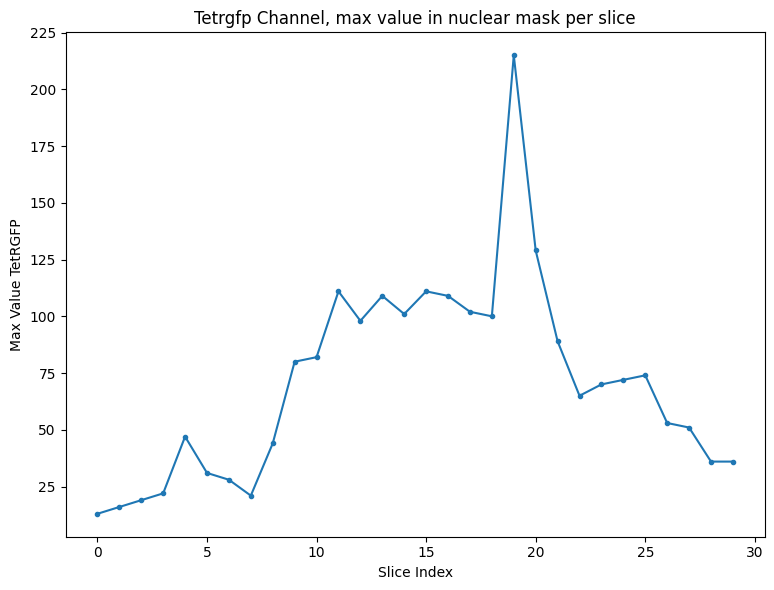

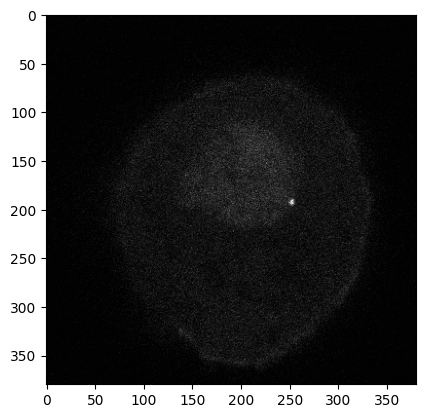

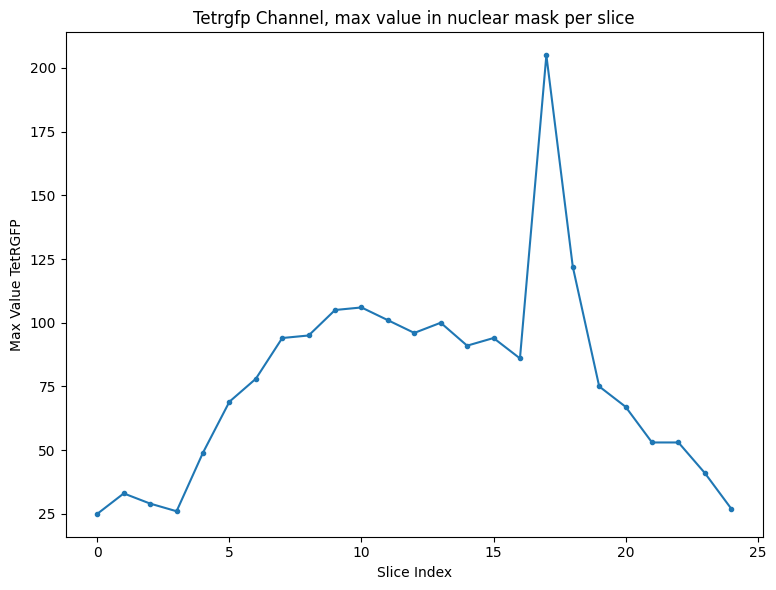

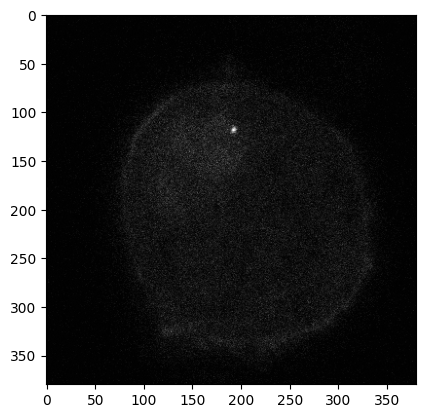

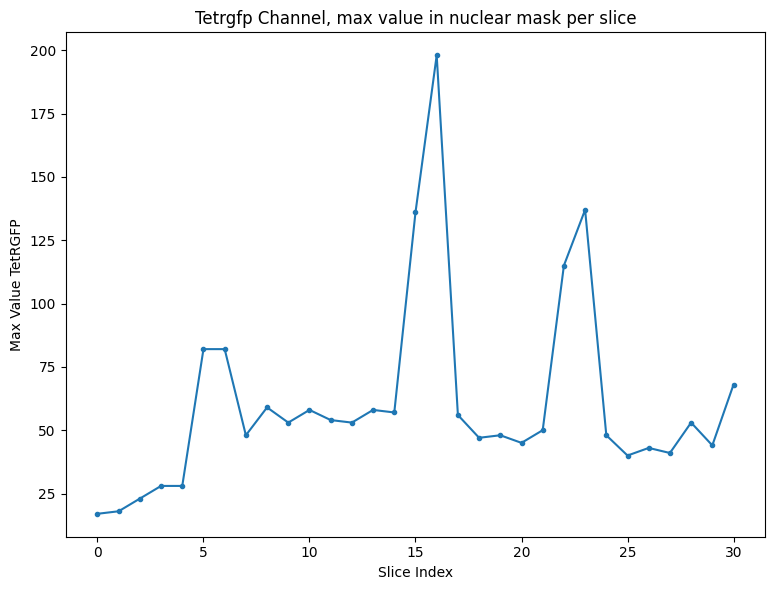

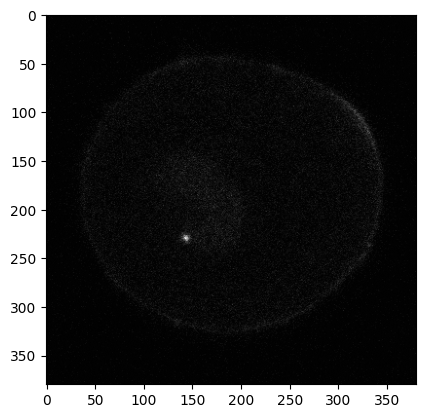

In [9]:
inpath = ("/inpath/in/")
outpath = ("/outpath/out/")

find_spot_slice(inpath, outpath, savefig=True)
